# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [3]:
import matplotlib.pyplot as plt 
import requests
from pprint import pprint
import numpy as np
import json
import pandas as pd
from api_keys import weather_api_key
from scipy import stats
import random
import time
import datetime

## Generate Cities List

In [4]:
#create the path and acces the data
filepath = "../citipy/worldcities.csv"
cities_data = pd.read_csv(filepath)
cities_data = cities_data.drop_duplicates()
#describe the data
print('North atmosphere')
print('-----------------------------')
print(cities_data[cities_data["Latitude"]>0].describe())
print('-----------------------------')
print('South atmosphere')
print('-----------------------------')
print(cities_data[cities_data["Latitude"]<0].describe())
count_north = cities_data[cities_data["Latitude"]>0].describe().iloc[0,0]
count_south = cities_data[cities_data["Latitude"]<0].describe().iloc[0,0]
print('-----------------------------')
print(f'{round((count_north/(count_north+count_south))*100,2)}% of the cities are in the north atmosphere')

North atmosphere
-----------------------------
           Latitude     Longitude
count  41893.000000  41893.000000
mean      35.903554     17.349714
std       16.299358     69.489081
min        0.016667   -179.500000
25%       20.466667     -6.037314
50%       40.980556     21.483333
75%       48.383333     69.377778
max       78.216667    179.316667
-----------------------------
South atmosphere
-----------------------------
          Latitude    Longitude
count  4939.000000  4939.000000
mean    -16.684873    -3.754199
std      10.588629    74.690333
min     -54.800000  -176.183333
25%     -23.695436   -51.650000
50%     -16.400000   -39.833333
75%      -7.216667    34.750000
max      -0.033333   178.666667
-----------------------------
89.45% of the cities are in the north atmosphere


In [5]:
#I will choose the cities randomly according to:
## The min and the max(from -54 to 78) and by 10 degres
bins = np.arange(-60,90,10)
labels = ["<-50","-50:-41","-40:-31","-30:-21","-20:-11","-10:-0",
            "1:10","11:20","21:30","31:40","41:50","51:60","61:70","70>"]
cities_data["Cuts"] = pd.cut(cities_data["Latitude"],bins = bins, labels = labels, include_lowest = True)

#choose randomly in the quartiles selected
cities_random = []
random.seed(20)
for cut in labels:
    grouped = cities_data[cities_data["Cuts"] == cut]
    if len(list(grouped["City"]))<=45:
        for city in list(grouped["City"]):
            cities_random.append(city)
    else :
        samples = random.sample(list(grouped["City"]),45)
        for city in samples:
           cities_random.append(city)

print(len(cities_random))

573


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
#use the API to find the information needed
base_url = f"http://api.openweathermap.org/data/2.5/weather?appid={weather_api_key}&units=imperial&q="
#create empty lists
cities_df = {}
#looping through the API responses to retrieve the right informations
set = 1
count = 0
print("Beginning Data Retrieval\n-----------------------------")
for city in cities_random:
    response = requests.get(base_url + str(city)).json()
    #pprint(response)
    try: 
        cities_df[city] = response["id"],response["sys"]["country"],response["name"],response["dt"],response["coord"]["lat"],response["coord"]["lon"],response["clouds"]["all"],response["main"]["humidity"],response["wind"]["speed"],response["main"]["temp_max"]
        print(f"Processing Record {count} of Set {set} | {city}")
        count += 1    
    except:
        print(f"{city} not found, Skipping ..")
    if count%50 == 0:
        time.sleep(2)
        set += 1
        count = 0
print("-----------------------------\nData Retrieval Complete\n-----------------------------")

rd 36 of Set 2 | limache
Processing Record 37 of Set 2 | palmares do sul
Processing Record 38 of Set 2 | mildura
Processing Record 39 of Set 2 | armidale
Processing Record 40 of Set 2 | opotiki
Processing Record 41 of Set 2 | americana
Processing Record 42 of Set 2 | lalmatie
Processing Record 43 of Set 2 | igarape
Processing Record 44 of Set 2 | videira
Processing Record 45 of Set 2 | garca
Processing Record 46 of Set 2 | bauru
Processing Record 47 of Set 2 | candido mota
Processing Record 48 of Set 2 | paicandu
Processing Record 49 of Set 2 | goya
Processing Record 0 of Set 3 | bras-panon
Processing Record 1 of Set 3 | piracicaba
Processing Record 2 of Set 3 | ballitoville
Processing Record 3 of Set 3 | viljoenskroon
Processing Record 4 of Set 3 | soledade
Processing Record 5 of Set 3 | maunatlala
Processing Record 6 of Set 3 | providence
Processing Record 7 of Set 3 | thohoyandou
Processing Record 8 of Set 3 | andira
Processing Record 9 of Set 3 | mhlambanyatsi
Processing Record 10 

In [10]:
cities_df = pd.DataFrame(cities_df)
cities_df = cities_df.transpose().rename(columns = {0 : "City_ID", 1 : "Country", 2:"City",3: "Date",
                                4:"Lat",5:"Long",6: "Cloudiness",7:"Humidity",8:"Wind_Speed",9:"Temp_Max" })
cities_df = cities_df.reset_index(drop = True)

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [11]:
outputpath = "../output_data/cities.csv"
cities_df.to_csv(outputpath, encoding = "UTF-8",index = False, header=True)
cities_df.head()

,City_ID,Country,City,Date,Lat,Long,Cloudiness,Humidity,Wind_Speed,Temp_Max
0,3838859,AR,Río Gallegos,1601343508,-51.62,-69.22,79,75,10.29,32
1,3833367,AR,Ushuaia,1601343509,-54.8,-68.3,40,92,11.41,32
2,3874787,CL,Punta Arenas,1601343273,-53.15,-70.92,20,91,10.29,32
3,4845585,US,Westport,1601343222,41.14,-73.36,20,88,6.93,69.8
4,3874930,CL,Puerto Varas,1601343511,-41.32,-72.99,90,93,4.7,48.2


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [12]:
print(f'There are {cities_df[cities_df["Humidity"]>100]["City"].count()} city with a humidity over 100%')

There are 0 city with a humidity over 100%


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [13]:
timestamp = cities_df["Date"][0]
value = datetime.datetime.fromtimestamp(timestamp)
date = f"{value:%d/%m/%Y}"
print(f"We will base our analysis on historical data took on : {date}")

We will base our analysis on historical data took on : 29/09/2020


Observations
-----------------------------
* The plot shows the relation between the temp max for cities around the world chosen randomly through different latitudes.
* We can observe that the more we approach the lat 0 (Equator), the higher the temperatire maximum is. The further from the Equator,the cooler.
-----------------------------


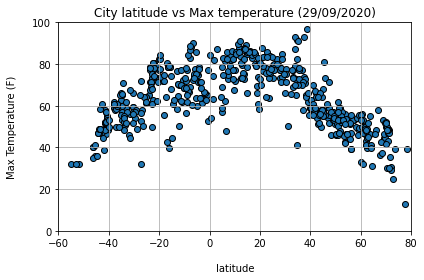

In [14]:
plt.scatter(cities_df["Lat"],cities_df["Temp_Max"], edgecolors="black")
plt.ylabel("Max Temperature (F)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.xlim(-60,80)
plt.ylim(0,100)
plt.title(f"City latitude vs Max temperature ({date})")
plt.grid()
plt.tight_layout()
plt.savefig("../output_data/Maxtemp.png")
print("Observations")
print("-----------------------------")
print("* The plot shows the relation between the temp max for cities around the world chosen randomly through different latitudes.")
print("* We can observe that the more we approach the lat 0 (Equator), the higher the temperatire maximum is. The further from the Equator,the cooler.")
print("-----------------------------")

## Latitude vs. Humidity Plot

Observations
-----------------------------
* The plot shows the relation between the humidity for cities around the world chosen randomly through different latitudes.
* The relation between is not as apparent. We can observe a light pattern around some latitudes (lower level of humidity around the latitude 20) but we certainly can't generalise. However we can observe a high humidity level from the Equator to the lat 20 North.
-----------------------------


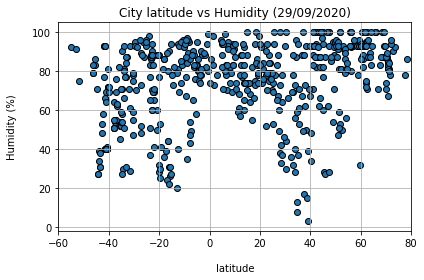

In [15]:
x = cities_df["Lat"]
y = cities_df["Humidity"]
plt.scatter(x,y, edgecolors="black")
plt.ylabel("Humidity (%)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.xlim(-60,80)
plt.title(f"City latitude vs Humidity ({date})")
plt.grid()
plt.tight_layout()
plt.savefig("../output_data/Humidity.png")
print("Observations")
print("-----------------------------")
print("* The plot shows the relation between the humidity for cities around the world chosen randomly through different latitudes.")
print("* The relation between is not as apparent. We can observe a light pattern around some latitudes (lower level of humidity around the latitude 20) but we certainly can't generalise. However we can observe a high humidity level from the Equator to the lat 20 North.")
print("-----------------------------")

## Latitude vs. Cloudiness Plot

Observations
-----------------------------
* The plot shows the relation between the cloudiness for cities around the world chosen randomly through different latitudes.
* We can observe that the latitude doesn't affect as much the level of clouds. However we can observe that the majority of the cities have either 0%,20%, 80% or 100% of cloudiness.
-----------------------------


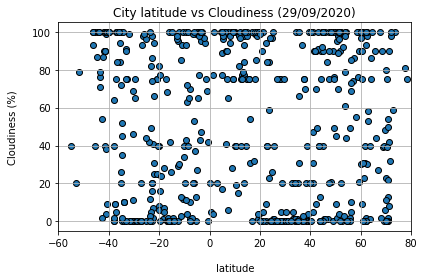

In [16]:
x = cities_df["Lat"]
y = cities_df["Cloudiness"]
plt.scatter(x,y, edgecolors="black")
plt.ylabel("Cloudiness (%)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.xlim(-60,80)
plt.title(f"City latitude vs Cloudiness ({date})")
plt.grid()
plt.tight_layout()
plt.savefig("../output_data/Cloudiness.png")
print("Observations")
print("-----------------------------")
print("* The plot shows the relation between the cloudiness for cities around the world chosen randomly through different latitudes.")
print("* We can observe that the latitude doesn't affect as much the level of clouds. However we can observe that the majority of the cities have either 0%,20%, 80% or 100% of cloudiness.")
print("-----------------------------")

## Latitude vs. Wind Speed Plot

Observations
-----------------------------
* The plot shows the relation between the wind speed for cities around the world chosen randomly through different latitudes.
* We can observe that in general all cities have the same wind speed range level. However we see that some cities with closer latitude from the poles have a higher wind speed level.
-----------------------------


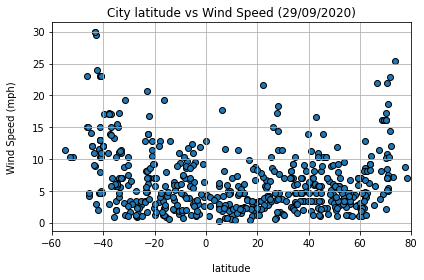

In [17]:
x = cities_df["Lat"]
y = cities_df["Wind_Speed"]
plt.scatter(x,y, edgecolors="black")
plt.ylabel("Wind Speed (mph)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.xlim(-60,80)
plt.title(f"City latitude vs Wind Speed ({date})")
plt.grid()
plt.tight_layout()
plt.savefig("../output_data/WindSpeed.png")
print("Observations")
print("-----------------------------")
print("* The plot shows the relation between the wind speed for cities around the world chosen randomly through different latitudes.")
print("* We can observe that in general all cities have the same wind speed range level. However we see that some cities with closer latitude from the poles have a higher wind speed level.")
print("-----------------------------")

## Linear Regression

In [18]:
citiesN_df = cities_df[cities_df["Lat"]>0]
citiesS_df = cities_df[cities_df["Lat"]<0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

the r-value is : 0.6721503810326143


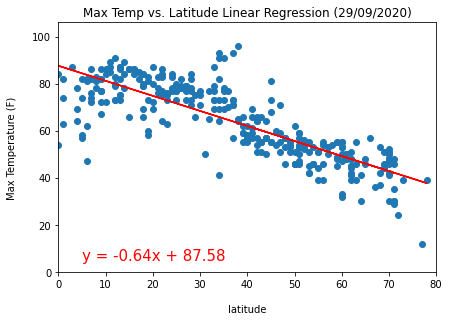

In [35]:
def plotN(x,y):
    (m,b,r,p,sem) = stats.linregress(x,y)
    regress_value = m*x + b
    line_eq = f"y = {round(m,2)}x + {round(b,2)}"
    plt.scatter(x,y)
    plt.plot(x,regress_value,c="r")
    plt.annotate(line_eq,(5,5), c="r", fontsize = 15)
    plt.xlim(0,max(x)+2)
    plt.ylim(0,max(y)+10)
    plt.tight_layout()
    print(f"the r-value is : {r**2}")

x = citiesN_df["Lat"].astype('int')
y = citiesN_df["Temp_Max"].astype('int')
plotN(x,y)
plt.ylabel("Max Temperature (F)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.title(f"Max Temp vs. Latitude Linear Regression ({date})")
plt.savefig("../output_data/MaxtempNorth.png")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

the r-value is : 0.45604108427039064


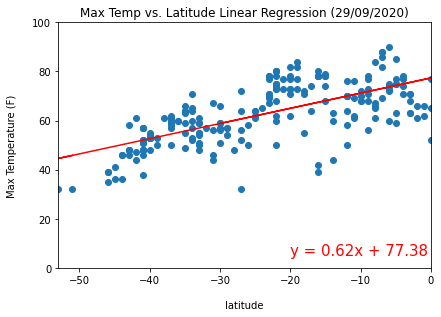

In [39]:
def plotS(x,y):
    (m,b,r,p,sem) = stats.linregress(x,y)
    regress_value = m*x + b
    line_eq = f"y = {round(m,2)}x + {round(b,2)}"
    plt.scatter(x,y)
    plt.plot(x,regress_value,c="r")
    plt.annotate(line_eq,(-20,5), c="r", fontsize = 15)
    plt.xlim(min(x)+1,0)
    plt.ylim(0,max(y)+10)
    plt.tight_layout()
    print(f"the r-value is : {r**2}")



x = citiesS_df["Lat"].astype('int')
y = citiesS_df["Temp_Max"].astype('int')
plotS(x,y)
plt.ylabel("Max Temperature (F)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.title(f"Max Temp vs. Latitude Linear Regression ({date})")
plt.savefig("../output_data/MaxtempSouth.png")

[Observations South vs North]
* We can observe that the variation of Max temp is explained for 65%(North) by the latitude which means a moderate effect size.
* We can observe that the variation of Max temp is explained for 47%(South) by the latitude which means a weak effect size.
* We can't predict the max temp only with the latitude but the linear regression gives us an idea.
* We don't have any data for cities below -54 lat which could be helpfull to have a more accurate linear regression for the southern Hemisphere.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

the r-value is : 0.02578979496109824


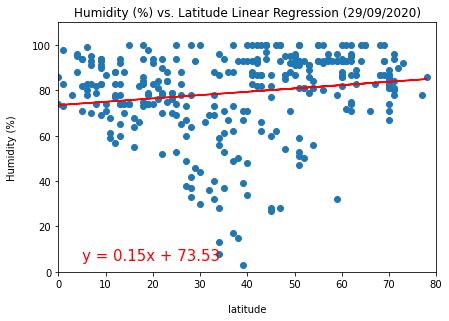

In [40]:
x = citiesN_df["Lat"].astype('int')
y = citiesN_df["Humidity"].astype('int')
plotN(x,y)
plt.ylabel("Humidity (%)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.title(f"Humidity (%) vs. Latitude Linear Regression ({date})")
plt.savefig("../output_data/HumidityNorth.png")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

the r-value is : 0.06778835851850093


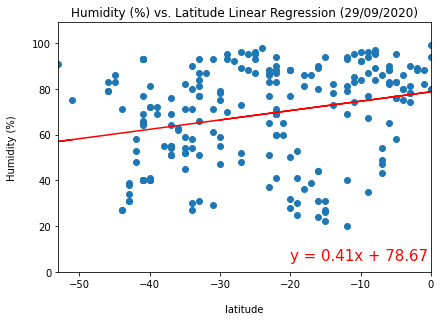

In [41]:
x = citiesS_df["Lat"].astype('int')
y = citiesS_df["Humidity"].astype('int')
plotS(x,y)
plt.ylabel("Humidity (%)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.title(f"Humidity (%) vs. Latitude Linear Regression ({date})")
plt.savefig("../output_data/HumiditySouth.png")

[Observations]
* We can observe that the variation of Humidity is not explained by the latitude.(No effect size , r-squared <0.3)
* The linear regression is not the best predictive model for the Humidity.
* There is not a clear pattern in the 2 different Hemispheres.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

the r-value is : 0.009818398990466881


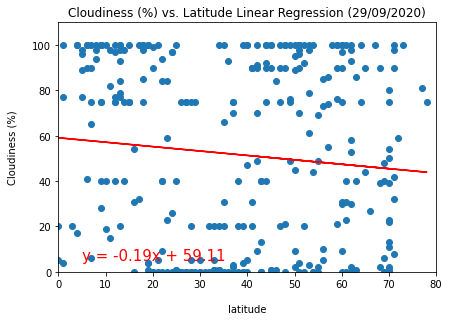

In [42]:
x = citiesN_df["Lat"].astype('int')
y = citiesN_df["Cloudiness"].astype('int')
plotN(x,y)
plt.ylabel("Cloudiness (%)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.title(f"Cloudiness (%) vs. Latitude Linear Regression ({date})")
plt.savefig("../output_data/CloudinessNorth.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

the r-value is : 0.0192200962879135


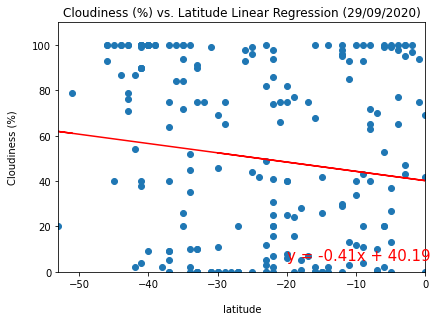

In [44]:
x = citiesS_df["Lat"].astype('int')
y = citiesS_df["Cloudiness"].astype('int')
plotS(x,y)
plt.ylabel("Cloudiness (%)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.title(f"Cloudiness (%) vs. Latitude Linear Regression ({date})")
plt.savefig("../output_data/CloudinessSouth.png")

[Observations]
* We can observe that the variation of Cloudiness is not explained by the latitude. (No effect size , r-squared <0.3)
* The linear regression is not the best predictive model for the Cloudiness.
* The Hemispheres have a similar pattern described earlier but not explained by the latitude.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

the r-value is : 0.09716853346739938


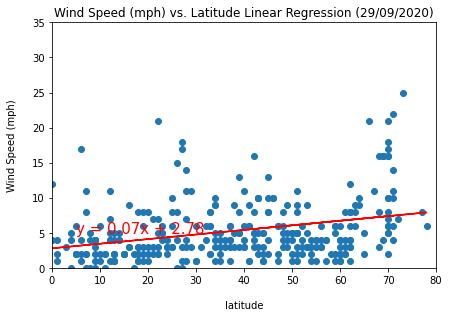

In [45]:
x = citiesN_df["Lat"].astype('int')
y = citiesN_df["Wind_Speed"].astype('int')
plotN(x,y)
plt.ylabel("Wind Speed (mph)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.title(f"Wind Speed (mph) vs. Latitude Linear Regression ({date})")
plt.savefig("../output_data/WindSpeedNorth.png")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

the r-value is : 0.19397097868893387


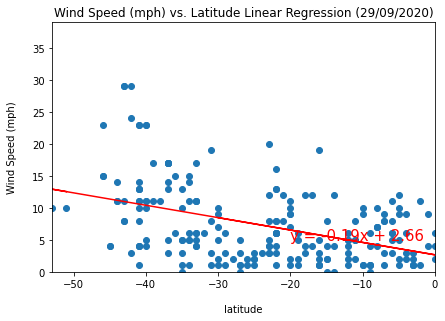

In [46]:
x = citiesS_df["Lat"].astype('int')
y = citiesS_df["Wind_Speed"].astype('int')
plotS(x,y)
plt.ylabel("Wind Speed (mph)", labelpad= 15)
plt.xlabel("latitude", labelpad= 15)
plt.title(f"Wind Speed (mph) vs. Latitude Linear Regression ({date})")
plt.savefig("../output_data/WindSpeedSouth.png")

[Observations]
* We can observe that the variation of wind speed is not explained by the latitude. (No effect size , r-squared <0.3)
* The linear regression is not the best predictive model for the Wind speed.
* The Hemispheres have a similar pattern described earlier but not explained by the latitude.